In [1]:
%pylab inline
from IPython.display import HTML
tau = 2.0 * pi

Populating the interactive namespace from numpy and matplotlib


In [2]:
circular_svg = '''
<svg version="1.1" width=220 height=220>
 <g transform="translate(110, 110)">
  <circle cx=0 cy=0 r=100 stroke=lightgray stroke-width=1 fill=none />
  <g class="anim %s">
   <line x1=0 y1=0 x2=100 y2=0 stroke=lightgray />
   <circle cx=100 cy=0 r=5 fill=#bb0 />
  </g>
  <circle cx=0 cy=0 r=3 fill=#040 />
 </g>
</svg>
'''

HTML(circular_svg % 'stationary')

In [3]:
circular_style = '''
<style>
.anim {
 animation-duration: 10s;
 animation-iteration-count: infinite;
} 
.uniform {
 animation-name: uniform;
 animation-timing-function: linear;
}
@keyframes uniform {
 to {transform: rotate(360deg);}
}
</style>
'''

HTML(circular_svg % 'uniform' + circular_style)

In [4]:
equant_svg = '''
<svg version="1.1" width=300 height=220>
 <g transform="translate(110, 110)">
  <circle cx=0 cy=0 r=2 fill=gray />
  <circle cx=0 cy=0 r=100 stroke=lightgray stroke-width=1 fill=none />
  <g class="anim %s">
   <circle cx=100 cy=0 r=5 fill=#bb0 />
  </g>
  <g transform="translate(%s, 0)">
   <circle cx=0 cy=0 r=2 fill=gray />
   <g class="anim uniform">
    <line x1=0 y1=0 x2=%s y2=0 stroke=lightgray />
   </g>
  </g>
 </g>
</svg>
'''

HTML(equant_svg % ('stationary', 70, 170))

In [5]:
HTML(equant_svg % ('uniform', 70, 170))

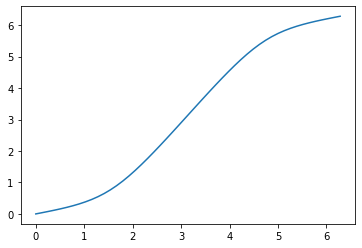

In [6]:
def equant_E(M, e):
    return M - arcsin(e * np.sin(M))

M = linspace(0, tau)
E = equant_E(M, 0.7)
plot(M, E);

In [7]:
def bezier(t, x1, y1, x2, y2):
    m = 1 - t
    p = 3 * m * t
    b, c, d = p * m, p * t, t * t * t
    return (b * x1 + c * x2 + d,
            b * y1 + c * y2 + d)

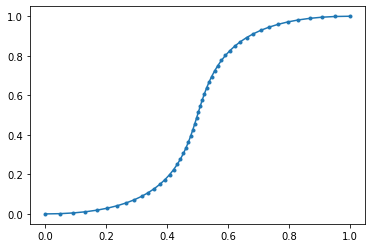

In [8]:
t = linspace(0, 1)
xb, yb = bezier(t, 0.8, 0, 0.2, 1)
plot(xb, yb, '.-')

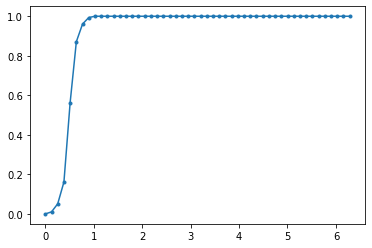

In [9]:
plot(M, interp(M, xb, yb), '.-')

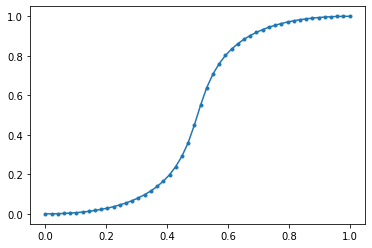

In [10]:
plot(M/tau, interp(M/tau, xb, yb), '.-')

In [11]:
def bezier_in_a_box(M0, M1, E0, E1):
    def boxed(M, x1, y1, x2, y2):
        t = linspace(0, 1)
        xb, yb = bezier(t, x1, y1, x2, y2)
        x = (M - M0) / (M1 - M0)
        y = interp(x, xb, yb)
        return E0 + (E1 - E0) * y
    return boxed

In [12]:
from scipy.optimize import curve_fit

boxed = bezier_in_a_box(0, tau, 0, tau)
guess = [0.5, 0.0, 0.5, 1.0]
args, var = curve_fit(boxed, M, E, guess, bounds=[0,1])
args

array([0.47532029, 0.06537691, 0.52467971, 0.93462309])

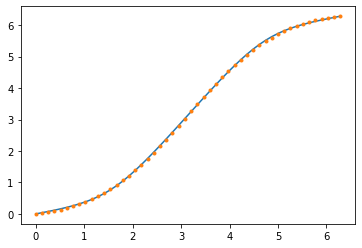

In [13]:
plot(M, E)
plot(M, boxed(M, *args), '.')

In [14]:
max(abs(E - boxed(M, *args))) * 360 / tau

1.980801996224498

In [15]:
bezier1_css = '''
<style>
.bezier1 {
  animation-name: bezier1;
}
@keyframes bezier1 {
 from {animation-timing-function: %s}
 to {transform: rotate(360deg)}
}
</style>
'''

In [16]:
def cb(args):
    argstr = ', '.join('%.3f' % n for n in args)
    return 'cubic-bezier(%s)' % argstr

cb(args)

'cubic-bezier(0.475, 0.065, 0.525, 0.935)'

In [17]:
css = bezier1_css % cb(args)
HTML(equant_svg % ('bezier1', 70, 170) + css)

In [18]:
KEYFRAME = '''\
%.3f%% {
 transform: rotate(%.3frad);
 animation-timing-function: %s;
}
'''

boundaries = [0, tau/3, 2*tau/3, tau]
keyframes = []
for M0, M1 in zip(boundaries[:-1], boundaries[1:]):
    M = linspace(M0, M1)
    E = equant_E(M, 0.7)
    boxed = bezier_in_a_box(M0, M1, E[0], E[-1])
    args, v = curve_fit(boxed, M, E, bounds=[0,1])
    percent = M0 / tau * 100
    keyframe = KEYFRAME % (percent, E[0], cb(args))
    keyframes.append(keyframe)
    
print(''.join(keyframes))

0.000% {
 transform: rotate(0.000rad);
 animation-timing-function: cubic-bezier(0.480, 0.206, 0.681, 0.333);
}
33.333% {
 transform: rotate(1.443rad);
 animation-timing-function: cubic-bezier(0.298, 0.264, 0.702, 0.736);
}
66.667% {
 transform: rotate(4.840rad);
 animation-timing-function: cubic-bezier(0.319, 0.667, 0.520, 0.794);
}



In [19]:
bezier2_css = '''
<style>
.bezier2 {
  animation-duration: 10s;
  animation-iteration-count: infinite;
  animation-name: bezier2;
}
@keyframes bezier2 {
 %s
 to {transform: rotate(360deg)}
}
</style>
'''

In [20]:
css = bezier2_css % ''.join(keyframes)
html = equant_svg % ('bezier2', 70, 170) + css
HTML(html)

In [21]:
len(html)

958